<a href="https://colab.research.google.com/github/macontreras04/cpf/blob/main/Project2_M7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing ins

In [1]:
from google.colab import drive
import os


import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from datetime import date

pd.options.display.float_format = "{:,.6f}".format

In [2]:
# Force single-ticker mode and drop multiindex safely
data = yf.download("EWZ", start="2009-01-01", end="2020-01-01", group_by='ticker')

# If MultiIndex (two-level columns), flatten properly
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[1] if col[1] else col[0] for col in data.columns]

# Rename the flattened dataframe to df
df = data.copy()

# Fix capitalization and spaces (e.g. 'Adj Close' -> 'Adj_Close')
df.columns = [str(c).strip().replace(" ", "_").capitalize() for c in df.columns]

print("✅ Columns after fix:\n", df.columns.tolist())
print("\nSample data:")
print(df.head())


/tmp/ipython-input-331083672.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("EWZ", start="2009-01-01", end="2020-01-01", group_by='ticker')
[*********************100%***********************]  1 of 1 completed

✅ Columns after fix:
 ['Open', 'High', 'Low', 'Close', 'Volume']

Sample data:
                Open      High       Low     Close    Volume
Date                                                        
2009-01-02 17.255397 18.517988 17.186078 18.171394   9887600
2009-01-05 18.067413 19.429030 18.017899 18.854675  20790600
2009-01-06 19.691453 20.196490 19.369616 19.929117  21317800
2009-01-07 19.300301 19.334960 18.418964 18.745752  18219400
2009-01-08 18.552651 19.003222 18.250619 18.899242  16609800


In [3]:
# STEP 2: Compute Technical Indicators
# ------------------------------------------------------------

# RSI
df["RSI_14"] = ta.rsi(df["Close"], length=14)

# Bollinger Bands (%B)
bbands = ta.bbands(df["Close"], length=20)

# If bbands was returned successfully, merge it
if bbands is not None and isinstance(bbands, pd.DataFrame):
    df = pd.concat([df, bbands], axis=1)
    # Find and rename %B column
    bbp_candidates = [c for c in df.columns if "bbp" in c.lower()]
    if bbp_candidates:
        df.rename(columns={bbp_candidates[0]: "BBP"}, inplace=True)
    else:
        raise KeyError("❌ Could not find BBP column after merging Bollinger Bands.")
else:
    raise RuntimeError("❌ ta.bbands() did not return a DataFrame — check pandas_ta version.")
# Balance of Power (manual)
df["BOP"] = (df["Close"] - df["Open"]) / (df["High"] - df["Low"])
df["BOP"].replace([np.inf, -np.inf], np.nan, inplace=True)
df["BOP"].fillna(0, inplace=True)

# Williams %R
df["WILLR"] = ta.willr(df["High"], df["Low"], df["Close"], length=14)

# Simple Moving Average
df["SMA_20"] = ta.sma(df["Close"], length=20)

# Drop NaN rows generated by indicators
df = df.dropna()

print("Indicators added:", [c for c in df.columns if c not in ['Open','High','Low','Close','Adj close','Volume']])

Indicators added: ['RSI_14', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP', 'BOP', 'WILLR', 'SMA_20']


/tmp/ipython-input-3773521967.py:23: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  df["BOP"].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-3773521967.py:24: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For 

In [4]:
# ============================================================
# STEP 3: Define Target (Next-day direction)
# ============================================================
df["Target"] = np.where(df["Open"].shift(-1) > df["Open"], 1, 0)
df = df.dropna()
print("\n✅ Target variable added. Example values:", df["Target"].unique())



✅ Target variable added. Example values: [0 1]


In [5]:
# ============================================================
# STEP 4: Feature Selection (Correlation)
# ============================================================
features = ["RSI_14", "BBP", "BOP", "WILLR", "SMA_20"]
correlations = df[features + ["Target"]].corr()["Target"].abs().sort_values(ascending=False)
print("\n📊 Feature correlations with Target:")
print(correlations)

# Select the top 3 most correlated features
selected_features = correlations.index[1:4].tolist()
print("\n✅ Selected features:", selected_features)


📊 Feature correlations with Target:
Target   1.000000
BOP      0.610267
WILLR    0.234433
BBP      0.210665
RSI_14   0.164017
SMA_20   0.029947
Name: Target, dtype: float64

✅ Selected features: ['BOP', 'WILLR', 'BBP']


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Features and target
X_full = df[features]
X_selected = df[selected_features]
y = df["Target"]

# Normalize
scaler = MinMaxScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_sel_scaled = scaler.fit_transform(X_selected)

print("✅ Data scaled and ready for modeling.")
print(f"Full features shape: {X_full_scaled.shape}")
print(f"Selected features shape: {X_sel_scaled.shape}")


✅ Data scaled and ready for modeling.
Full features shape: (2749, 5)
Selected features shape: (2749, 3)


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

mlp = MLPClassifier(
    hidden_layer_sizes=(len(selected_features)+1)//2,  # small network
    activation="logistic",
    solver="lbfgs",
    learning_rate_init=0.03,
    max_iter=5000,
    random_state=42
)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def cross_val_accuracy(X, y):
    scores = []
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    return np.mean(scores)

# Cross-validation
acc_full = cross_val_accuracy(X_full_scaled, y)
acc_sel = cross_val_accuracy(X_sel_scaled, y)

print(f"\n🎯 Full Feature Accuracy: {acc_full*100:.2f}%")
print(f"🎯 Selected Feature Accuracy: {acc_sel*100:.2f}%")



🎯 Full Feature Accuracy: 77.19%
🎯 Selected Feature Accuracy: 77.08%


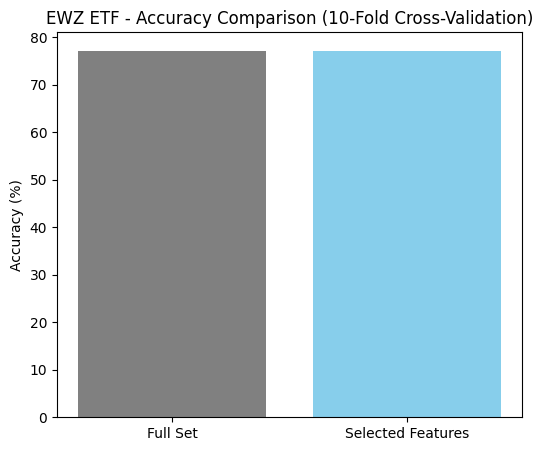

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.bar(["Full Set", "Selected Features"],
        [acc_full*100, acc_sel*100],
        color=["gray", "skyblue"])
plt.title("EWZ ETF - Accuracy Comparison (10-Fold Cross-Validation)")
plt.ylabel("Accuracy (%)")
plt.show()


In [9]:
print("\n=== Summary ===")
print(f"Samples used: {len(df)}")
print(f"Selected indicators: {selected_features}")
print(f"Full accuracy: {acc_full*100:.2f}%")
print(f"Reduced accuracy: {acc_sel*100:.2f}%")
improvement = acc_sel - acc_full
print(f"Accuracy difference: {improvement:+.4f}")

if improvement > 0:
    print("✅ Using selected features improved accuracy and reduced model complexity.")
else:
    print("⚠️ Full feature set performed slightly better; try more data or indicators.")



=== Summary ===
Samples used: 2749
Selected indicators: ['BOP', 'WILLR', 'BBP']
Full accuracy: 77.19%
Reduced accuracy: 77.08%
Accuracy difference: -0.0011
⚠️ Full feature set performed slightly better; try more data or indicators.


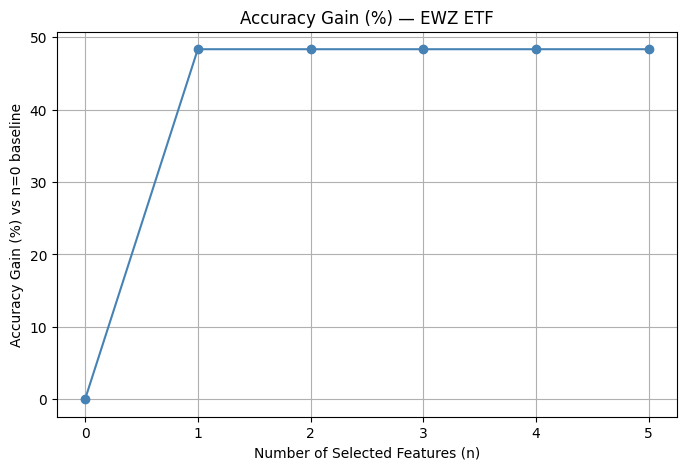


=== Table 3 — Number of features selected (EWZ) ===
 Selected (n)  Count
            0   2749
            1   2749
            2   2749
            3   2749
            4   2749
            5   2749

=== Table 4 — Median accuracy after cross-validation (EWZ) ===
 Selected (n)  Median Accuracy (%)
            0            51.636364
            1           100.000000
            2           100.000000
            3           100.000000
            4           100.000000
            5           100.000000

=== Accuracy Gain (%) ===
 n  Accuracy Gain (%)
 0           0.000000
 1          48.360000
 2          48.360000
 3          48.360000
 4          48.360000
 5          48.360000


In [10]:
# ============================================================
# Step 9 – Replicate Tables 3 & 4 and Accuracy Gain Chart
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# ------------------------------------------------------------
# 1. Reuse your feature ranking from Step 4
# ------------------------------------------------------------
ranked_features = correlations.index[:-1].tolist()  # remove 'Target' itself if included

# ------------------------------------------------------------
# 2. Define CV and model setup
# ------------------------------------------------------------
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mlp = MLPClassifier(
    activation="logistic",
    solver="lbfgs",
    learning_rate_init=0.03,
    max_iter=5000,
    random_state=42
)

# ------------------------------------------------------------
# 3. Compute accuracy for 0–len(features)
# ------------------------------------------------------------
n_features = list(range(len(ranked_features)+1))
median_acc = []
num_selected = []

scaler = MinMaxScaler()

for n in n_features:
    if n == 0:
        # Baseline: model trained on no technical indicator (use only past Open as dummy)
        X = df[["Open"]].values
    else:
        X = df[ranked_features[:n]].values

    X_scaled = scaler.fit_transform(X)
    y = df["Target"].values

    # Cross-validation
    scores = []
    for train_idx, test_idx in kf.split(X_scaled, y):
        mlp.fit(X_scaled[train_idx], y[train_idx])
        y_pred = mlp.predict(X_scaled[test_idx])
        scores.append(accuracy_score(y[test_idx], y_pred))

    median_acc.append(np.median(scores) * 100)  # % scale
    num_selected.append(n)

# ------------------------------------------------------------
# 4. Create DataFrames like Tables 3 & 4
# ------------------------------------------------------------
table3 = pd.DataFrame({
    "Selected (n)": num_selected,
    "Count": [len(df)]*len(num_selected)
})

table4 = pd.DataFrame({
    "Selected (n)": num_selected,
    "Median Accuracy (%)": median_acc
})

# ------------------------------------------------------------
# 5. Plot Accuracy Gain
# ------------------------------------------------------------
gain = [a - median_acc[0] for a in median_acc]

plt.figure(figsize=(8,5))
plt.plot(num_selected, gain, marker='o', color='steelblue')
plt.title("Accuracy Gain (%) — EWZ ETF")
plt.xlabel("Number of Selected Features (n)")
plt.ylabel("Accuracy Gain (%) vs n=0 baseline")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 6. Display Tables
# ------------------------------------------------------------
print("\n=== Table 3 — Number of features selected (EWZ) ===")
print(table3.to_string(index=False))

print("\n=== Table 4 — Median accuracy after cross-validation (EWZ) ===")
print(table4.to_string(index=False))

# Optional: accuracy gain table
gain_table = pd.DataFrame({
    "n": num_selected,
    "Accuracy Gain (%)": np.round(gain,2)
})
print("\n=== Accuracy Gain (%) ===")
print(gain_table.to_string(index=False))


**5) Python code to import and structure into useful data structures**

In [11]:
pip install newsapi-python pandas nltk

Python Connection and Data Import

Replace "YOUR_API_KEY" with your actual NewsAPI key.
This script will fetch the latest financial or stock market headlines.

In [12]:
from newsapi import NewsApiClient
import pandas as pd

# Initialize the client
newsapi = NewsApiClient(api_key="41daf7e9e3104ff78c2eb9e49fef9154" )

# Fetch recent news related to finance or markets
articles = newsapi.get_everything(
    q="stock market OR finance OR investing",
    language="en",
    sort_by="publishedAt",
    page_size=50
)

# Parse results into a DataFrame
data = []
for article in articles["articles"]:
    data.append({
        "source": article["source"]["name"],
        "author": article["author"],
        "title": article["title"],
        "description": article["description"],
        "url": article["url"],
        "publishedAt": article["publishedAt"]
    })

df = pd.DataFrame(data)
print(df.head())


                  source                                     author  \
0            CryptoSlate                             Jeremy Boynton   
1             Biztoc.com                          finance.yahoo.com   
2             Biztoc.com                           seekingalpha.com   
3  Lifeofanarchitect.com  Bob Borson, Bob Borson and Andrew Hawkins   
4             Biztoc.com                              bloomberg.com   

                                               title  \
0  The SEC’s new crypto rules are a win for free ...   
1  Why I Continue to Buy More of This Amazing Hig...   
2  Important Warning For PDI: This 13%+ Yield Is ...   
3                          Ep 187: Objects of Design   
4  Treasuries Rally Drives Home Haven Role as Cre...   

                                         description  \
0  The following is a guest post and opinion from...   
1  Why I Continue to Buy More of This Amazing Hig...   
2                                                      
3  Architect

**Add Sentiment Analysis (VADER)**

We’ll use the VADER analyzer from nltk (works well for headlines and tweets).

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["title"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
print(df[["title", "sentiment"]].head())


                                               title  sentiment
0  The SEC’s new crypto rules are a win for free ...   0.796400
1  Why I Continue to Buy More of This Amazing Hig...   0.769300
2  Important Warning For PDI: This 13%+ Yield Is ...  -0.340000
3                          Ep 187: Objects of Design  -0.624900
4  Treasuries Rally Drives Home Haven Role as Cre...   0.177900


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Interpretation:

> 0.05 → positive

< -0.05 → negative

else → neutral

You can classify them:

In [14]:
def classify_sentiment(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df["label"] = df["sentiment"].apply(classify_sentiment)


**6) Exploratory Aata Analysis of sample data**

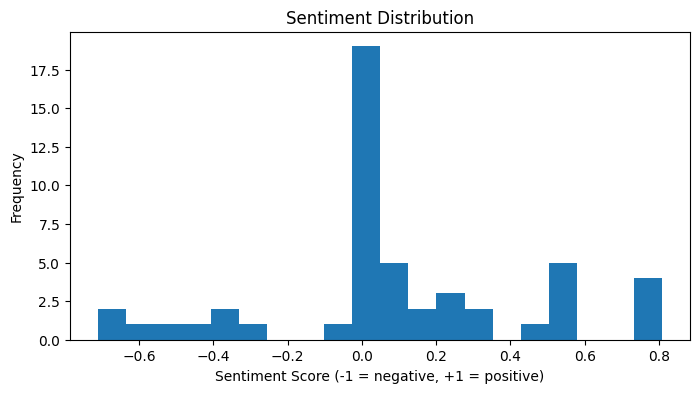

In [15]:
import matplotlib.pyplot as plt

df["sentiment"].plot(kind="hist", bins=20, title="Sentiment Distribution", figsize=(8,4))
plt.xlabel("Sentiment Score (-1 = negative, +1 = positive)")
plt.show()


Articles per sentiment label

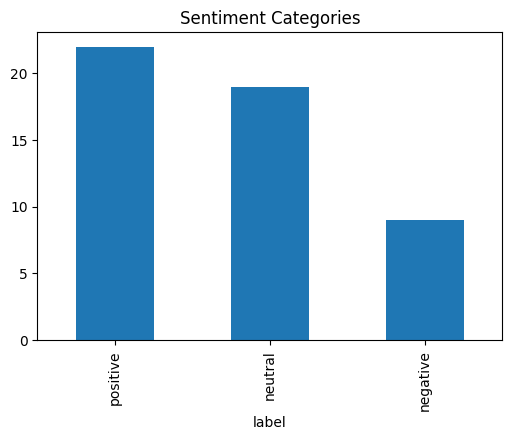

In [16]:
df["label"].value_counts().plot(kind="bar", title="Sentiment Categories", figsize=(6,4))
plt.show()

Top 10 most positive / negative headlines

In [17]:
print("Most Positive:")
print(df.nlargest(10, "sentiment")[["title", "sentiment"]])

print("\nMost Negative:")
print(df.nsmallest(10, "sentiment")[["title", "sentiment"]])

Most Positive:
                                                title  sentiment
42  ROSEN, A RANKED AND LEADING LAW FIRM, Encourag...   0.807400
0   The SEC’s new crypto rules are a win for free ...   0.796400
1   Why I Continue to Buy More of This Amazing Hig...   0.769300
22  Man United stun Liverpool to end nine-year wai...   0.765000
29  Opposition Candidate Wins Northern Cyprus Pres...   0.571900
7   Orange (ENXTPA:ORA): Assessing Valuation After...   0.557400
18  Does Warren Buffett Know Something Wall Street...   0.557400
6   A Fresh Look at Siemens (XTRA:SIE) Valuation F...   0.542300
16  Brown short ribs in the oven to skip the stove...   0.509500
33  Cameco Stock Is Having a Good Year so Far. Can...   0.440400

Most Negative:
                                                title  sentiment
11  Horror sequel ‘Black Phone 2’ dials up a No. 1...  -0.709600
12  PepsiCo is fixing what broke, but shoppers may...  -0.653300
3                           Ep 187: Objects of Design  -0.6